In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set()

In [3]:
data = pd.read_csv('./data/agg_df_with_full_text.csv', converters={
    "users": literal_eval,
    "scores": literal_eval
    })
dimension_to_id = {dim: j for j,dim in enumerate(set(data['dimension']))}
annotator_set = set([id_ for j,row in data.iterrows() for id_ in row['users']])
ann_to_id = {ann: j for j,ann in enumerate(annotator_set)}
instance_to_row = {id_: j for j,id_ in enumerate(set(data['instance_id']))}

In [4]:
data.columns

Index(['instance_id', 'scores', 'users', 'scores_num', 'label', 'dimension',
       'doi', 'url', 'Mention title', 'category', 'outlet', 'coverage_type',
       'statement', 'FleschReadingEase', 'big_field', 'cleaned_text',
       'statement_full', 'split'],
      dtype='object')

## Demographic information

In [ ]:
question2key = {
    "What is your gender?": "gender",
    "What is your age?": "age",
    "How do you describe your race or ethnicity (You may select more than one option)": "race",
    "What is your education level?": "education",
    'How frequently do you read science news?': "science_news_consumption",
   'Which of the following, if any, do you regularly get your science news from (Select all that apply)?': "get_news_from_outlets",
   'Which, if any, of these science-related topics are you interested in?':'topic_of_interests',
   'In general, how much would you say that you trust science?':"trust_in_science",
   'In general, how much do you trust scientists to find out accurate information about the world?':"trust_in_scientist_ability",
   'How much do you trust scientists to do their work with the intention of benefiting the public?':"trust_in_scientist_intentin",
   'How much do you know about what scientists do?':"knowledge_about_scientists",
   'How satisfied do you feel about your experience participating our study?':"study_experience",
   'How do you feel about your experience participating our study compared with other studies?':"study_experience_comparison",
   'If you choose Asian above, please specify (please choose Not Applicable if you are not Asian)':"Asian_details",
   'What is your employment status?': "employment"
}

def load_info_dict(path='data/selective-reporting/annotation/news_values/surveyflow', files = ['demographic_information','experience_with_science','political_orientation']):
    info_dict = {}
    question_dict = {}
    for f in files:
        info_dict[f] = {}
        t_df = pd.read_json(os.path.join(path, f) + '.jsonl', orient='records', lines=True)
        for i,row in t_df.iterrows():
            info_dict[f][row['text']] = dict(row)
            question_dict[row['text']] = dict(row)
            question_dict[row['text']]['category'] = f
    return info_dict, question_dict

def read_csv(path, cat):
    df = pd.read_csv(path,sep='\t')
    df['sample'] = cat
    return df

info_dict, question_dict = load_info_dict()
labels = ['Strongly Disagree', 'Disagree', 'Neutral', 'Agree' , 'Strongly Agree']
label2score = {l:i for i,l in enumerate(labels)}

def convert_data(df, multirate_keys = ['Readability and newsworthiness', 'Practical implications and controversy', 'Sharing','benefit','publishing']):
    return_dict = defaultdict(list)
    cols = list(df.columns)
    for i, row in df.iterrows():
        item = {}
        for key_label in cols:
            key = key_label.split(":::")
            if len(key) == 1:
                item[key[0]] = row[key_label]
            elif key[0] == 'span_annotation':
                item[key[0]] = eval(row[key_label])
            elif key[1]=='bad_text':
                item['bad_text'] = row[key_label]
            elif len(key) == 2:
                #print(key_label, row[key_label])
                if key[0] in multirate_keys:
                    if str(row[key_label]) == 'nan':
                        item[key_label] = np.nan
                    else:
                        item[key_label] = label2score[row[key_label]]
                elif key[0] in question_dict:
                    if question_dict[key[0]]['schema'] == 'radio':
                        if key[0] not in item:
                            item[key[0]] = np.nan
                        if str(row[key_label]) != 'nan':
                            item[key[0]] = key[1]
                    elif question_dict[key[0]]['schema'] == 'multiselect':
                        if key[0] not in item:
                            item[key[0]] = []
                        if str(row[key_label]) != 'nan':
                            item[key[0]].append(key[1])
                    
                else:
                    #print(str(row[key_label]))
                    if key[0] not in item:
                        item[key[0]] = None

                    elif str(row[key_label]) != 'nan':
                        item[key[0]] = row[key_label]
                
                #if key[0] not in item:
                #    item[key[0]] = None
                #if row[key_label] == True:
                #    if key[1][:5] == 'scale':
                #        item[key[0]] = int(key[1].split('_')[1])
                #    else:
                #        item[key[0]] = key[1]
            else:
                print('error key: ', key)
        for key in item:
            return_dict[key].append(item[key])
    for key in return_dict:
        print(key,len(return_dict))
    return pd.DataFrame(return_dict)

def get_user_dict(ann_df):
    user_keys = set(ann_df['user'])
    user_dict = defaultdict(dict)
    for key in info_dict:
        df = ann_df[ann_df.instance_id.str.contains(key)]
        for i, row in df.iterrows():
            for k in info_dict[key]:
                user_dict[row['user']][k] = row[k]#.split(':::')[-1] if type(v)==str else v
    return user_dict


data_df = pd.concat([
    read_csv('data/selective-reporting/annotation/news_values/annotation_output/full/batch_1/US/annotated_instances.tsv','US'),
    read_csv('data/selective-reporting/annotation/news_values/annotation_output/full/batch_1/UK/annotated_instances.tsv','UK')
])
data_df = convert_data(data_df)
user_dict = get_user_dict(data_df)


In [ ]:
user_dict

In [ ]:
info_dict

# PCA stuff

In [29]:
# Get all the data in a nice tensor I x D x A
# I: instance
# D: dimension
# A: annotator
#annotation_tensor = np.array([[[-1]*len(ann_to_id)]*len(dimension_to_id)]*len(instance_to_row))
score_vector_set = defaultdict(lambda: [np.nan]*len(dimension_to_id))
for j,row in data.iterrows():
    for ann,score in zip(row['users'], row['scores']):
        score_vector_set[(row['instance_id'],ann)][dimension_to_id[row['dimension']]] = score
# Get a matrix of scores
score_mat = np.array(list(score_vector_set.values()))

In [ ]:
from sklearn.impute import KNNImputer

# Impute missing values
imputer = KNNImputer(n_neighbors=2, weights="uniform")
score_mat_full = imputer.fit_transform(score_mat)

In [ ]:
mu = score_mat_full.mean(0)
diffs = score_mat_full - mu
# Divide by N - 1 for unbaised estimate
cov = (diffs.T @ diffs) / (score_mat_full.shape[0] - 1)

# Compute eigenvectors and eigenvalues
eig = np.linalg.eig(cov)
# Get percentage of explained variance
pVar = eig[0] / eig[0].sum()
# Sort eigenvectors and eigenvalues
order = np.argsort(eig[0])[::-1]
# Eigenvectors stored as column vectors
features = eig[1][:,order]

# Reduce to K dimensions
K = 2
pca_vectors = features[:,:K].T @ diffs.T

In [ ]:
plt.scatter(pca_vectors[0], pca_vectors[1], s=1)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_vecs = pca.fit_transform(score_mat_full)
plt.scatter(test_vecs[:,0], test_vecs[:,1], s=1)

In [ ]:
(test_vecs.T - pca_vectors).mean()

## See if any clusters come up based on user or instance attributes

In [ ]:
# Get instance categories for each row
inst_to_cat = {row['instance_id']: row['category'] for j,row in data.iterrows()}
categories = [inst_to_cat[key[0]] for key in score_vector_set]

# Get instance field for each row
inst_to_field = {row['instance_id']: row['big_field'] for j,row in data.iterrows()}
fields = [inst_to_field[key[0]] for key in score_vector_set]

# Get user gender for each for
gender = [user_dict[key[1]]['What is your gender?'] for key in score_vector_set]

# Get user age
age = [user_dict[key[1]]['What is your age?'] for key in score_vector_set]

In [ ]:
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=10, hue=categories)

In [ ]:
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=10, hue=fields)

In [ ]:
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=10, hue=gender)

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=15, hue=age)

# K-Means Clustering

In [51]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(pca_vectors.T)

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=15, hue=kmeans.labels_)

In [ ]:
# Get statistics on the two clusters
inst_to_cluster = {key[0]: lab for key,lab in zip(score_vector_set, kmeans.labels_)}
inst_to_cluster = {key[0]: lab for key,lab in zip(score_vector_set, kmeans.labels_)}

# Get aggregated article level features

In [27]:
import os
import tensorflow as tf
from tensorboard.plugins import projector

2023-10-24 11:02:29.871482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
agg_vectors = defaultdict(lambda: [np.nan]*len(dimension_to_id))
labels_dict = defaultdict(dict)
for j,row in data.iterrows():
    agg_vectors[row['instance_id']][dimension_to_id[row['dimension']]] = row['label']
    labels_dict[row['instance_id']]['category'] = row['category']
    labels_dict[row['instance_id']]['outlet'] = row['outlet']
    labels_dict[row['instance_id']]['field'] = row['big_field']
# Get a matrix of scores
score_mat = np.array(list(score_vector_set.values()))

In [ ]:
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='./tensorboard/embeddings'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
# Make embeddings and labels
embs = []
labs = []
for id_ in agg_vectors:
    embs.append(np.array(agg_vectors[id_]))
    cat = labels_dict[id_]['category']
    outlet = labels_dict[id_]['outlet']
    field = labels_dict[id_]['field']
    labs.append(f"{id_}\t{cat}\t{outlet}\t{field}")
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    f.write("ID\tCategory\tOutlet\tField\n")
    f.write("\n".join(labs))
    
# center and normalize the vectors: we make everything symmetric and have magnitude 1, so 
# we can look at cosine similarity
embs = np.array(embs)
embs -= embs.mean(0, keepdims=True)
embs = embs / np.linalg.norm(embs, axis=1, keepdims=True)

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(np.array(embs))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
np.linalg.norm(embs, axis=1).shape

In [ ]:
data.head()

In [ ]:
A = np.array([[1, 2], [-1,3]])
A0 = np.array([[1, -0.5], [-1, 0.5]])
sns.scatterplot(x=A[:,0], y=A[:,1])

sns.scatterplot(x=A0[:,0], y=A0[:,1])

In [ ]:
A

# Latent factor model to learn embeddings of users and articles

We'll build a latent factor model (as in collaborative filtering). We have a matrix $U \in \mathbb{R}^{N \times d}$ where $U_{n}$ is the embedding for user $n$; matrix $I \in \mathbb{R}^{M \times d}$ where $I_{m}$ is the embdding of item $m$ and a sparse matrix $S \in \mathbb{R}^{N \times M}$ where $S_{nm}$ is the score that user $n$ gave to item $m$.

Given a set of $K$ tuples $(n, m, r) \in \tilde{S}$ where $k$ is the rating user $n$ gave to item $k$, we learn $U$ and $I$ by optimizing the following objective:

$$\mathcal{L}(U, I, \tilde{S}) = \frac{1}{K}\sum_{(n,m,r) \in \tilde{S}}\left\lVert U_{n}I_{m} - r \right\rVert_{2}^{2}$$

In [ ]:
# First attempt custom solver using pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset
import random
from torch.utils.data import DataLoader

def enforce_reproducibility(seed=1000):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

class MatrixFactorizer(nn.Module):
    def __init__(self, n, m, d):
        super().__init__()
        # Create embedding matrices for U and I
        self.U = nn.Embedding(n, d)
        self.I = nn.Embedding(m, d)
        
    def forward(self, 
                mn: torch.LongTensor):
        # Get the embeddings and return their dot product
        m = mn[:,0]
        n = mn[:,1]
        u = self.U(n)
        i = self.I(m)
        return (u*i).sum(-1)
    
class IterDataset(Dataset):
    def __init__(self, dataset):
        self.dset = dataset
        
    def __len__(self):
        return len(self.dset)
    
    def __getitem__(self, idx):
        item = self.dset[idx]
        mn = torch.LongTensor([item[0], item[1]])
        r = torch.FloatTensor([item[2]]).squeeze()
        
        return nm,r

In [ ]:
# Make everything reproducible
enforce_reproducibility()

In [ ]:
# Get the data in tuples
rating_key = 'Readability and newsworthiness:::The science news story should be published in the news'
dataset = []
scores = []
for j,row in data.iterrows():
    if row['dimension'] == rating_key:
        for ann,score in zip(row['users'], row['scores']):
            dataset.append([instance_to_row[row['instance_id']], ann_to_id[ann], score])
            scores.append(score)
# Normalize by subtracting the mean and dividing my stddev
dataset = np.array(dataset)
dataset[:,-1] = (dataset[:,-1] - dataset[:,-1].mean()) / dataset[:,-1].std()

In [ ]:
dset = IterDataset(dataset)
loader = DataLoader(dset, batch_size=8, shuffle=True)
model = MatrixFactorizer(len(ann_to_id), len(instance_to_row), 16)

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.001)
# loss_fn = nn.MSELoss()
# epochs = 1000
# for e in range(epochs):
#     print(f"Epoch: {e}")
#     for nm,r in loader:

#         optimizer.zero_grad()
#         out = model(nm)
#         loss = loss_fn(out, r)
#         loss.backward()
#         optimizer.step()

#     print(loss)

In [ ]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV

model = NeuralNetRegressor(
    module=MatrixFactorizer,
    max_epochs=150,
    batch_size=8,
    lr=0.001,
    optimizer=optim.AdamW,
    module__n=len(ann_to_id), 
    module__m=len(instance_to_row), 
    module__d=4
)

X = dataset[:,:-1].astype(np.int64)
Y = dataset[:,1].astype(np.float32)

In [ ]:
param_grid = {
    'max_epochs': [10,20,30],
    'lr': np.logspace(np.log(0.0001), np.log(0.01), 20, base=np.exp(1))
}
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=3, error_score='raise', n_iter=20)
grid_result = grid.fit(X, Y)

      7   177106.0370   182298.6601  0.3023
      8   177064.9026   182297.2560  0.5022
      9   177023.5851   182295.8267  0.3690
     10   176982.0442   182294.3875  0.3919
     11   176940.2358   182292.9326  0.3201
     12   176898.1142   182291.4576  0.2989
     13   176855.6321   182289.9695  0.2833
     14   176812.7433   182288.4471  0.3037
     15   176769.4006   182286.8814  0.3050
     16   176725.5639   182285.2535  0.4137
     17   176681.1888   182283.5504  0.3705
     18   176636.2424   182281.7659  0.3742
     19   176590.6818   182279.9186  0.3748
     20   176544.4761   182278.0218  0.3983
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   180360.0861   164453.2371  0.3696
      2   180325.1537   164455.0086  0.3695
      3   180284.4913   164456.8600  0.3880
      4   180242.3930   164458.7721  0.4465
      5   180199.6441   164460.7356  0.3863
      6   180156.4729   164462.7602  0.3498
      7   180112.9439   164464.8

In [ ]:
 np.logspace(np.log(0.00001), np.log(0.001), 20, base=np.exp(1))

In [ ]:
list(grid_result.best_estimator_.module_.U.parameters())[0]

In [25]:
data[(data['instance_id'] == 20) & (data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news')]['label']


1649    2.0
Name: label, dtype: float64

In [33]:
I = np.load('./Item.npy')
# Save them and see if there are clusters in tensorboard
# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir='./tensorboard/item_embeddings_rcv'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
# Make embeddings and labels
embs = []
labs = []
for id_ in agg_vectors:
    embs.append(np.array(I[id_]))
    cat = labels_dict[id_]['category']
    outlet = labels_dict[id_]['outlet']
    field = labels_dict[id_]['field']
    score = float(data[(data['instance_id'] == id_) & (data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news')]['label'])
    labs.append(f"{id_}\t{cat}\t{outlet}\t{field}\t{score}")
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    f.write("ID\tCategory\tOutlet\tField\tScore\n")
    f.write("\n".join(labs))
    
# center and normalize the vectors: we make everything symmetric and have magnitude 1, so 
# we can look at cosine similarity
embs = np.array(embs)
# embs -= embs.mean(0, keepdims=True)
# embs = embs / np.linalg.norm(embs, axis=1, keepdims=True)

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(np.array(embs))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_18666/3257283232.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  score = float(data[(data['instance_id'] == id_) & (data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news')]['label'])


In [66]:
user_score_dict = defaultdict(list)
for i,row in data[data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news'].iterrows():
    for user,score in zip(row['users'], row['scores']):
        user_score_dict[user].append(score)
    

In [72]:
U = np.load('./User_overfit.npy')
# Save them and see if there are clusters in tensorboard
# Set up a logs directory, so Tensorboard knows where to look for files.
id_to_user = {v:k for k,v in ann_to_id.items()}
log_dir='./tensorboard/user_embeddings'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
# Make embeddings and labels
labs = []
for i in range(U.shape[0]):
    gender = user_dict[id_to_user[i]]['What is your gender?']
    age = user_dict[id_to_user[i]]['What is your age?']
    score = np.array(user_score_dict[id_to_user[i]]).mean().round()
    labs.append(f"{i}\t{gender}\t{age}\t{score}")
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    f.write("ID\tGender\tAge\tAverage Score\n")
    f.write("\n".join(labs))
    
# center and normalize the vectors: we make everything symmetric and have magnitude 1, so 
# we can look at cosine similarity
embs = U#np.array(embs)
# embs -= embs.mean(0, keepdims=True)
# embs = embs / np.linalg.norm(embs, axis=1, keepdims=True)

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(np.array(embs))
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [65]:
data.columns

Index(['instance_id', 'scores', 'users', 'scores_num', 'label', 'dimension',
       'doi', 'url', 'Mention title', 'category', 'outlet', 'coverage_type',
       'statement', 'FleschReadingEase', 'big_field', 'statement_full'],
      dtype='object')

In [ ]:
# Get user gender for each for
gender = [user_dict[key[1]]['What is your gender?'] for key in score_vector_set]

# Get user age
age = [user_dict[key[1]]['What is your age?'] for key in score_vector_set]

In [ ]:
ann_to_id

In [40]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(I, I)

In [42]:
mask = np.ones(dists.shape, dtype=bool)
np.fill_diagonal(mask, 0)

In [45]:
dists[mask].min()

0.9633764

In [46]:
Ioverfit = np.load('./Item_overfit.npy')

In [47]:
overfit_dists = euclidean_distances(Ioverfit, Ioverfit)

In [48]:
overfit_dists[mask].min()

0.061591487

In [49]:
overfit_dists

array([[ 0.        ,  0.12364747, 21.362642  , ..., 19.873852  ,
        18.575727  , 18.780546  ],
       [ 0.12364747,  0.        , 21.35857   , ..., 19.83441   ,
        18.599684  , 18.752375  ],
       [21.362642  , 21.35857   ,  0.        , ..., 27.320564  ,
        29.350323  , 32.36317   ],
       ...,
       [19.873852  , 19.83441   , 27.320564  , ...,  0.        ,
        32.948593  , 25.803368  ],
       [18.575727  , 18.599684  , 29.350323  , ..., 32.948593  ,
         0.        , 24.297575  ],
       [18.780546  , 18.752375  , 32.36317   , ..., 25.803368  ,
        24.297575  ,  0.        ]], dtype=float32)

In [50]:
dists

array([[ 0.       ,  1.934025 , 12.929266 , ..., 14.045841 , 13.422909 ,
        12.856213 ],
       [ 1.934025 ,  0.       , 13.079902 , ..., 14.422361 , 13.407388 ,
        12.294878 ],
       [12.929266 , 13.079902 ,  0.       , ..., 23.146729 , 13.4432535,
        19.212042 ],
       ...,
       [14.045841 , 14.422361 , 23.146729 , ...,  0.       , 23.307251 ,
        21.756573 ],
       [13.422909 , 13.407388 , 13.4432535, ..., 23.307251 ,  0.       ,
        16.850729 ],
       [12.856213 , 12.294878 , 19.212042 , ..., 21.756573 , 16.850729 ,
         0.       ]], dtype=float32)

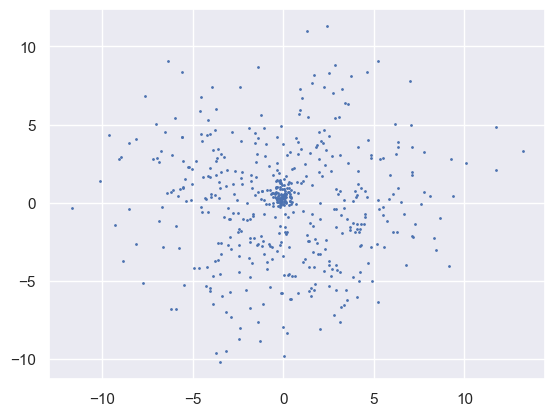

In [57]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
test_vecs = pca.fit_transform(I)
plt.scatter(test_vecs[:,0], test_vecs[:,1], s=1)

<Axes: >

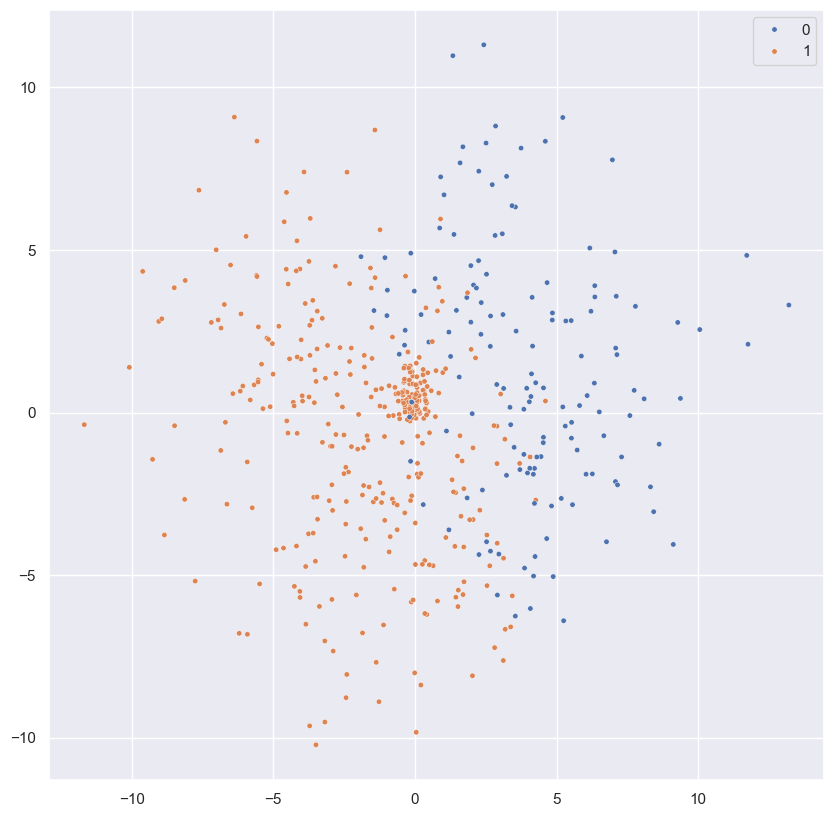

In [58]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(I)
plt.figure(figsize=(10,10))
sns.scatterplot(x=test_vecs[:,0], y=test_vecs[:,1], s=15, hue=kmeans.labels_)

In [59]:
embs = []
scores = []
for id_ in agg_vectors:
    embs.append(np.array(I[id_]))
    score = float(data[(data['instance_id'] == id_) & (data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news')]['label'])
    scores.append(score)

/var/folders/2t/bns057gs0ss5_m20xzbdwvwmb9fq40/T/ipykernel_18666/339131334.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  score = float(data[(data['instance_id'] == id_) & (data['dimension'] == 'Readability and newsworthiness:::The science news story should be published in the news')]['label'])


In [61]:
# TODO: load the actual articles and extract topics from them to see if there are any commonalities between the items